In [1]:
import pandas as pd
import collections
from itertools import product
import numpy as np
from matplotlib import pyplot
import seaborn

### Taking Excel Database Queries to Raw Data

In [151]:
test = pd.read_clipboard(header=None).drop(1, axis=1)

In [152]:
test.columns=['team'] + list(range(1,17))
test2 = pd.DataFrame(test.set_index('team').unstack().swaplevel(0, -1).unstack(0))
print(test2)
test2.to_csv('matchups_2019.csv',index=None)

team BALLS OF CHAOS CHOCOLATIERS CRAZY CAT'S EYES TEAM GALACTIC GREEN DUCKS  \
1               1--          1B*              2--           3B-         1A*   
2               1-*          1--              2--           1-*         2-*   
3               NaN          NaN              NaN           NaN         NaN   
4               1--          3--              3A*           2--         3B*   
5               1--          4A-              4B*           1A-         1B*   
6               1--          4--              4--           1B-         1A*   
7               NaN          NaN              NaN           NaN         NaN   
8               1A-          4A*              3--           2A*         1--   
9               1--          1B-              2--           4--         4A-   
10              1B-          4--              4--           2--         3A-   
11              1--          2--              2--           1--         1-*   
12              NaN          NaN              NaN   

In [192]:
pts = pd.read_clipboard(header=None)[[0, 5]]
print(pts.set_index(0))
pts.set_index(0).to_csv('ML_ptsAbbr.csv')

                    5
0                    
BALLS OF CHAOS    341
CHOCOLATIERS      316
CRAZY CAT'S EYES  221
GREEN DUCKS       204
HAZERS            295
INDIGO STARS      112
JAWBREAKERS       181
JUNGLE JUMPERS    204
KOBALTS            78
LIMERS            248
MELLOW YELLOW     480
MIDNIGHT WISPS    385
MINTY MANIACS      77
O'RANGERS         534
OCEANICS          388
PINKIES           360
RASPBERRY RACERS  326
ROJO ROLLERS      106
SAVAGE SPEEDERS   579
SHINING SWARM     112
SNOWBALLS         197
TEAM GALACTIC     447
TEAM MOMO         328
TEAM PRIMARY      157
THUNDERBOLTS      455


### Converting Raw Data to Rivalry Counts

In [2]:
def get_matchups(a, b, wgrp=True, debug=False):

    heats = {'grp': collections.OrderedDict.fromkeys(list(range(1, 17)), 0),
             'semi': collections.OrderedDict.fromkeys(list(range(1, 17)), 0),
             'fnl': collections.OrderedDict.fromkeys(list(range(1, 17)), 0),
             'tot': collections.OrderedDict.fromkeys(list(range(1, 17)), 0)}
    n = 1
    for i, j in zip(a, b):
        try:
            # Group: check if event has groups and placed in same grp
            if i[0] == j[0] and (i[0] != '#'):
                heats['grp'][n] = 1
            # Semis: Check if event has semis (always alphabetical) and both in same semi
            if (i[1] == j[1]) and (i[1] != '-') and not (i[1].isnumeric()):
                heats['semi'][n] = 1
            # Finals, no groups: Check if both teams placed in top 4
            if ((i[0] == '#') and (j[0] == '#')) and ((int(i[1:]) <= 4) and (int(j[1:]) <= 4)):
                heats['fnl'][n] = 1
            # Finals, with groups: Check if teams were in finals or semifinalists (point of isdigit())
            elif ((i[2] == j[2]) or (not (i[1].isnumeric()) and (i[2].isdigit() and j[2].isdigit()))
                 ) and (i[2] != '-') and (i[2] != ' '):
                heats['fnl'][n] = 1
        except TypeError:
            for Type in ['grp', 'semi', 'fnl']:
                heats[Type][n] = 0
        n += 1
    if debug:
        print(heats)
    matchup_tot =  sum(heats['semi'].values()) + sum(heats['fnl'].values())
    if wgrp:
        matchup_tot += sum(heats['grp'].values())
    return matchup_tot


In [3]:

def matchups_1year(year):
    test2=pd.read_csv('matchups_{}.csv'.format(year))
    matchups_yr = pd.DataFrame(columns=test2.columns, index=test2.columns)
    formatting = lambda x: (x.tolist())

    # a = collections.OrderedDict.fromkeys(test2.iloc[:,0].tolist())
    # b = collections.OrderedDict.fromkeys(test2.iloc[:,1].tolist())

    for i, j in product(list(range(0,25)), list(range(0,25))):
        out = get_matchups(formatting(test2.iloc[:,i]), formatting(test2.iloc[:,j])
                           ,wgrp=False) 
        matchups_yr.iloc[i, j] = out

    for i in range(0,25):
        matchups_yr.iloc[i, i] = np.nan
    return matchups_yr

out = matchups_1year(2016)
for comp in [2017, 2018, 2019]:
    out += matchups_1year(comp)
# sorting rows based on points
out = (out.join(pd.read_csv('ML_ptsAbbr.csv',index_col=0))
       .sort_values('5', ascending=False).drop('5', axis=1))
# sortinig columns symmetrically
out = out[out.index]
# deleting duplicate/ghost matches due to algorithm
# (in knockout tournaments, top 4 matched to all other 3 but in reality only faces 2/3)
out = out + pd.read_csv('mlpair_duplicates.csv',index_col=0)

In [4]:
out

,SAVAGE SPEEDERS,O'RANGERS,MELLOW YELLOW,THUNDERBOLTS,TEAM GALACTIC,OCEANICS,MIDNIGHT WISPS,PINKIES,BALLS OF CHAOS,TEAM MOMO,...,JUNGLE JUMPERS,GREEN DUCKS,SNOWBALLS,JAWBREAKERS,TEAM PRIMARY,INDIGO STARS,SHINING SWARM,ROJO ROLLERS,KOBALTS,MINTY MANIACS
SAVAGE SPEEDERS,NaN,8.0,6.0,8.0,6.0,7.0,8.0,6.0,7.0,7.0,...,3.0,5.0,5.0,2.0,2.0,2.0,0.0,0.0,1.0,1.0
O'RANGERS,8.0,NaN,6.0,9.0,10.0,8.0,7.0,6.0,8.0,5.0,...,3.0,3.0,2.0,1.0,2.0,1.0,4.0,1.0,2.0,0.0
MELLOW YELLOW,6.0,6.0,NaN,5.0,4.0,3.0,5.0,3.0,4.0,6.0,...,1.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0
THUNDERBOLTS,8.0,9.0,5.0,NaN,8.0,2.0,6.0,3.0,7.0,4.0,...,4.0,5.0,3.0,6.0,3.0,1.0,1.0,2.0,1.0,0.0
TEAM GALACTIC,6.0,10.0,4.0,8.0,NaN,3.0,8.0,3.0,6.0,5.0,...,3.0,2.0,1.0,1.0,2.0,0.0,3.0,2.0,1.0,0.0
OCEANICS,7.0,8.0,3.0,2.0,3.0,NaN,2.0,5.0,3.0,5.0,...,2.0,1.0,3.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0
MIDNIGHT WISPS,8.0,7.0,5.0,6.0,8.0,2.0,NaN,0.0,3.0,4.0,...,2.0,2.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0
PINKIES,6.0,6.0,3.0,3.0,3.0,5.0,0.0,NaN,1.0,6.0,...,2.0,3.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0
BALLS OF CHAOS,7.0,8.0,4.0,7.0,6.0,3.0,3.0,1.0,NaN,2.0,...,1.0,1.0,3.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0
TEAM MOMO,7.0,5.0,6.0,4.0,5.0,5.0,4.0,6.0,2.0,NaN,...,0.0,0.0,2.0,3.0,3.0,0.0,1.0,4.0,1.0,0.0


In [11]:
# For each team, find the team they've had most meaningful showdowns with
print(out.apply(lambda s: s.abs().nlargest(4).index.tolist(), axis=1))
# For each team, show the number of showdowns with the above rival
print(out.apply(lambda s: s.abs().nlargest(4).tolist(), axis=1))

SAVAGE SPEEDERS     [O'RANGERS, THUNDERBOLTS, MIDNIGHT WISPS, OCEA...
O'RANGERS           [TEAM GALACTIC, THUNDERBOLTS, SAVAGE SPEEDERS,...
MELLOW YELLOW       [CHOCOLATIERS, SAVAGE SPEEDERS, O'RANGERS, TEA...
THUNDERBOLTS        [O'RANGERS, SAVAGE SPEEDERS, TEAM GALACTIC, BA...
TEAM GALACTIC       [O'RANGERS, THUNDERBOLTS, MIDNIGHT WISPS, RASP...
OCEANICS                [O'RANGERS, SAVAGE SPEEDERS, HAZERS, PINKIES]
MIDNIGHT WISPS      [SAVAGE SPEEDERS, TEAM GALACTIC, O'RANGERS, TH...
PINKIES               [SAVAGE SPEEDERS, O'RANGERS, TEAM MOMO, LIMERS]
BALLS OF CHAOS      [O'RANGERS, SAVAGE SPEEDERS, THUNDERBOLTS, TEA...
TEAM MOMO           [SAVAGE SPEEDERS, MELLOW YELLOW, PINKIES, O'RA...
RASPBERRY RACERS    [JUNGLE JUMPERS, THUNDERBOLTS, TEAM GALACTIC, ...
CHOCOLATIERS        [MELLOW YELLOW, THUNDERBOLTS, TEAM GALACTIC, S...
HAZERS              [GREEN DUCKS, SAVAGE SPEEDERS, OCEANICS, O'RAN...
LIMERS              [SAVAGE SPEEDERS, PINKIES, O'RANGERS, TEAM GAL...
CRAZY CAT'S EYES    

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Gill Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(-0.15,-0.2,'Notes: \n "Meaningful Showdowns" are defined as two teams facing each other in \nany semifinal or any final, or when two teams place in the top four of a non-knockout event. \nCounts summed over all 2016-9 ML events, excluding qualifiers and ML Showdown.')

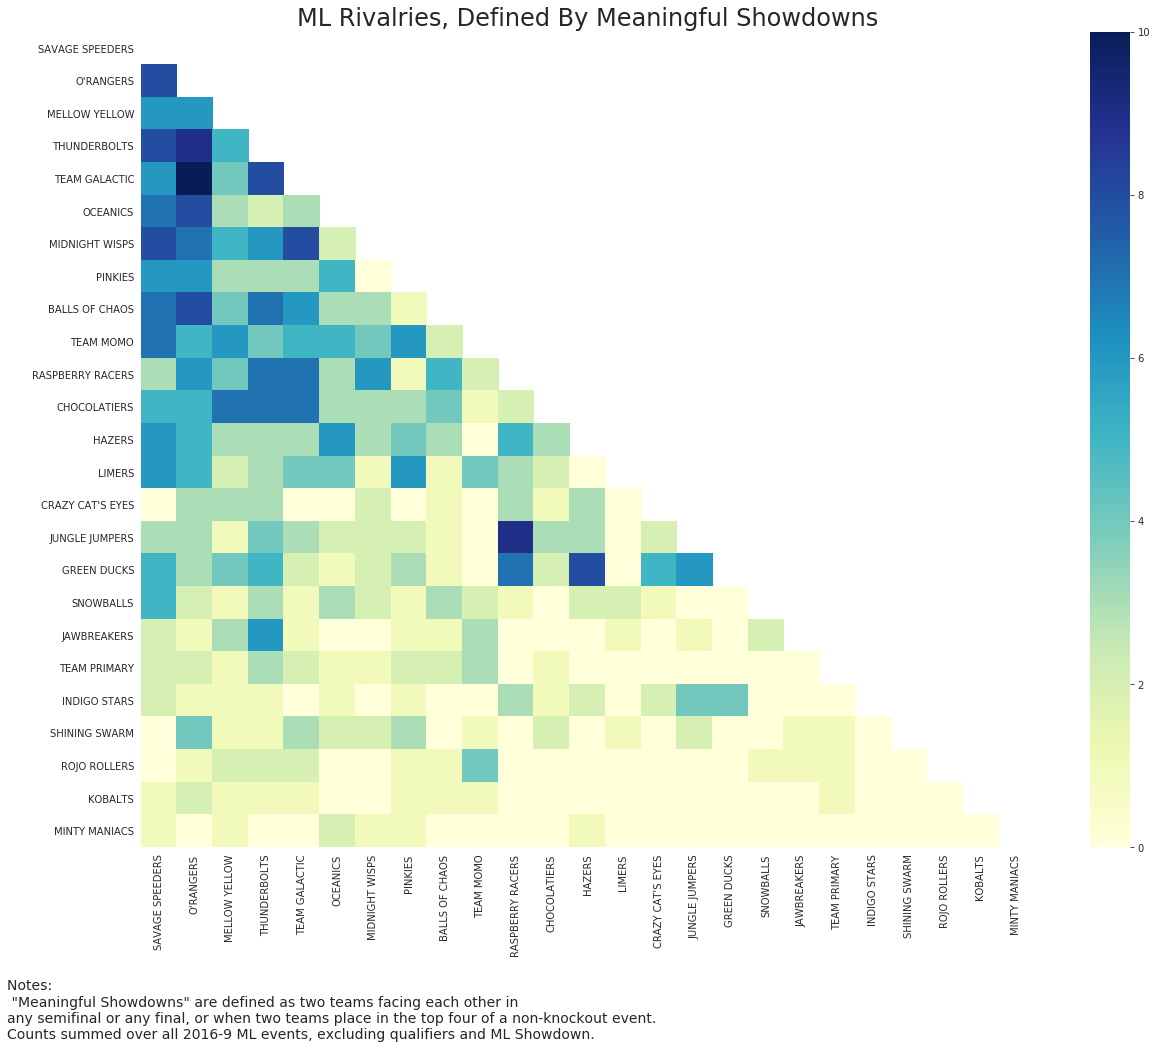

In [6]:
for i in range(0,25):
    out.iloc[i, i:] = np.nan
out.to_csv('MLRivalries_IO.csv')
    
seaborn.set_style("whitegrid")
pyplot.rcParams['font.family'] = 'Gill Sans'
fig, ax = pyplot.subplots(figsize=(20,15))
ax.set_title('ML Rivalries, Defined By Meaningful Showdowns', fontsize=24)
seaborn.heatmap(out, cmap='YlGnBu',yticklabels=1, cbar_kws={'ticks': list(range(0, 11, 2))})
pyplot.text(-0.15, -0.20,
            'Notes: \n "Meaningful Showdowns" are defined as two teams facing each other in \n'
            'any semifinal or any final, or when two teams place in the top four of a non-knockout event. \n'
            'Counts summed over all 2016-9 ML events, excluding qualifiers and ML Showdown.'
            , ha='left', va='center', fontsize=14, transform=ax.transAxes)

In [12]:
import matplotlib.font_manager

matplotlib.font_manager.createFontList(matplotlib.font_manager.findSystemFonts())

[<Font 'East Syriac Adiabene' (SyrCOMAdiabene.otf) normal normal 400 normal>,
 <Font 'STIXNonUnicode' (STIXNonUniIta.otf) italic normal 400 normal>,
 <Font 'Bitstream Vera Sans Mono' (VeraMoBd.ttf) normal normal bold normal>,
 <Font 'Serto Jerusalem' (SyrCOMJerusalemItalic.otf) italic normal 400 normal>,
 <Font 'Estrangelo Edessa' (SyrCOMEdessa.otf) normal normal 400 normal>,
 <Font 'Serto Batnan' (SyrCOMBatnan.otf) normal normal 400 normal>,
 <Font 'Bodoni Ornaments' (Bodoni Ornaments.ttf) normal normal 400 normal>,
 <Font '.SF Compact Rounded' (SFCompactRounded-Semibold.otf) normal normal 400 normal>,
 <Font 'Luxi Mono' (luximr.ttf) normal normal regular normal>,
 <Font 'Estrangelo Antioch' (SyrCOMAntioch.otf) normal normal 400 normal>,
 <Font 'Brush Script MT' (Brush Script.ttf) italic normal 400 normal>,
 <Font 'System Font' (SFNSDisplay-SemiboldItalic.otf) normal normal 400 normal>,
 <Font 'Luxi Sans' (luxisb.ttf) normal normal bold normal>,
 <Font 'Estrangelo Quenneshrin' (SyrCOM